# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os

####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
# LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 500
# scheduler_patience_mapping = {"CIFAR10": 200, "CIFAR100": 200, "ImageNet2012": 30}

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 80
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"

if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_128_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if valid_data is not None:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
else:
    valid_dataloader = None

if test_data is not None:
    test_dataloader = DataLoader(
        test_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("test.transforms =", test_data.transform, test_dataloader.batch_size)
else:
    test_dataloader = None

train.transforms = Compose(
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 128
test.transforms = ToTensor() 128


## Confirm that the dataset is loaded properly

Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32])
mean of X tensor([0.4942, 0.4903, 0.4476])
Shape of y: torch.Size([128]) torch.int64


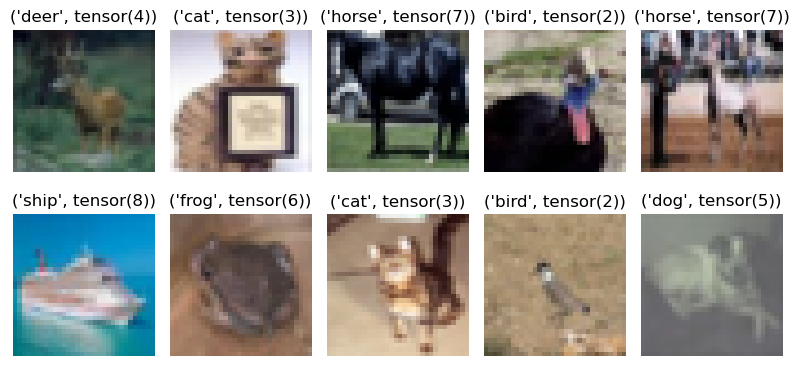

In [6]:
if test_data is not None:
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis("off")
            count += 1

            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-32 for CIFAR10 is loaded.


In [9]:
# model.named_modules

In [10]:
# tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
# flops = FlopCountAnalysis(model, tmp_input)
# print(flop_count_table(flops))

# Define Training

## (1) Define Criterion

In [11]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [12]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [13]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_path=file_path)

## (4) Define Learning Rate schedualer

In [14]:
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode="min",
#     patience=scheduler_patience_mapping[DATASET],
#     factor=0.1,
#     verbose=True,
#     threshold=1e-4,
#     cooldown=100,
# )

scheduler = MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
#
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [15]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [17]:
optimizer.param_groups[0]["lr"]

0.1

# [Training Loop]

In [18]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [19]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/500] :


100%|██████████| 391/391 [00:09<00:00, 41.78it/s]


Train Loss: 0.0058 | Train Acc: 10.00%
Test  Loss: 2.3102 | Test Acc: 9.99%
updated best eval loss : 2.310234416889239
--------------------------------------------------
[Epoch 2/500] :


100%|██████████| 391/391 [00:08<00:00, 44.39it/s]


Train Loss: 0.0049 | Train Acc: 23.75%
Test  Loss: 2.0019 | Test Acc: 24.86%
updated best eval loss : 2.0019291171544715
--------------------------------------------------
[Epoch 3/500] :


100%|██████████| 391/391 [00:08<00:00, 44.27it/s]


Train Loss: 0.0046 | Train Acc: 36.25%
Test  Loss: 1.7031 | Test Acc: 35.90%
updated best eval loss : 1.7031481673445883
--------------------------------------------------
[Epoch 4/500] :


100%|██████████| 391/391 [00:07<00:00, 48.91it/s]


Train Loss: 0.0044 | Train Acc: 41.25%
Test  Loss: 1.5687 | Test Acc: 41.62%
updated best eval loss : 1.5687306108354013
--------------------------------------------------
[Epoch 5/500] :


100%|██████████| 391/391 [00:08<00:00, 45.04it/s]


Train Loss: 0.0034 | Train Acc: 52.50%
Test  Loss: 1.1233 | Test Acc: 60.63%
updated best eval loss : 1.1233303712893137
--------------------------------------------------
[Epoch 6/500] :


100%|██████████| 391/391 [00:08<00:00, 45.15it/s]


Train Loss: 0.0028 | Train Acc: 61.25%
Test  Loss: 0.9828 | Test Acc: 64.89%
updated best eval loss : 0.9828344394889059
--------------------------------------------------
[Epoch 7/500] :


100%|██████████| 391/391 [00:08<00:00, 44.20it/s]


Train Loss: 0.0035 | Train Acc: 50.00%
Test  Loss: 0.9545 | Test Acc: 66.85%
updated best eval loss : 0.954494357863559
--------------------------------------------------
[Epoch 8/500] :


100%|██████████| 391/391 [00:09<00:00, 41.85it/s]


Train Loss: 0.0029 | Train Acc: 55.00%
Test  Loss: 0.8997 | Test Acc: 68.35%
updated best eval loss : 0.8997098969507821
--------------------------------------------------
[Epoch 9/500] :


100%|██████████| 391/391 [00:08<00:00, 46.45it/s]


Train Loss: 0.0022 | Train Acc: 63.75%
Test  Loss: 0.8575 | Test Acc: 71.38%
updated best eval loss : 0.8574842622008505
--------------------------------------------------
[Epoch 10/500] :


100%|██████████| 391/391 [00:08<00:00, 44.47it/s]


Train Loss: 0.0024 | Train Acc: 67.50%
Test  Loss: 0.8224 | Test Acc: 72.24%
updated best eval loss : 0.8224374761309805
--------------------------------------------------
[Epoch 11/500] :


100%|██████████| 391/391 [00:08<00:00, 44.62it/s]


Train Loss: 0.0029 | Train Acc: 67.50%
Test  Loss: 0.7347 | Test Acc: 74.72%
updated best eval loss : 0.7347478172447108
--------------------------------------------------
[Epoch 12/500] :


100%|██████████| 391/391 [00:08<00:00, 47.90it/s]


Train Loss: 0.0025 | Train Acc: 65.00%
Test  Loss: 0.6586 | Test Acc: 77.25%
updated best eval loss : 0.6586350342140922
--------------------------------------------------
[Epoch 13/500] :


100%|██████████| 391/391 [00:09<00:00, 42.52it/s]


Train Loss: 0.0020 | Train Acc: 73.75%
Test  Loss: 0.7014 | Test Acc: 76.56%
--------------------------------------------------
[Epoch 14/500] :


100%|██████████| 391/391 [00:09<00:00, 41.94it/s]


Train Loss: 0.0024 | Train Acc: 66.25%
Test  Loss: 0.6883 | Test Acc: 77.12%
--------------------------------------------------
[Epoch 15/500] :


100%|██████████| 391/391 [00:08<00:00, 45.34it/s]


Train Loss: 0.0024 | Train Acc: 67.50%
Test  Loss: 0.8301 | Test Acc: 73.01%
--------------------------------------------------
[Epoch 16/500] :


100%|██████████| 391/391 [00:08<00:00, 44.33it/s]


Train Loss: 0.0020 | Train Acc: 73.75%
Test  Loss: 0.7015 | Test Acc: 76.14%
--------------------------------------------------
[Epoch 17/500] :


100%|██████████| 391/391 [00:08<00:00, 46.40it/s]


Train Loss: 0.0022 | Train Acc: 75.00%
Test  Loss: 0.7624 | Test Acc: 74.71%
--------------------------------------------------
[Epoch 18/500] :


100%|██████████| 391/391 [00:08<00:00, 47.03it/s]


Train Loss: 0.0019 | Train Acc: 71.25%
Test  Loss: 0.7845 | Test Acc: 74.76%
--------------------------------------------------
[Epoch 19/500] :


100%|██████████| 391/391 [00:08<00:00, 46.90it/s]


Train Loss: 0.0020 | Train Acc: 62.50%
Test  Loss: 0.5831 | Test Acc: 80.14%
updated best eval loss : 0.583062995460969
--------------------------------------------------
[Epoch 20/500] :


100%|██████████| 391/391 [00:08<00:00, 45.42it/s]


Train Loss: 0.0019 | Train Acc: 77.50%
Test  Loss: 0.5774 | Test Acc: 80.56%
updated best eval loss : 0.5774414267721055
--------------------------------------------------
[Epoch 21/500] :


100%|██████████| 391/391 [00:08<00:00, 46.22it/s]


Train Loss: 0.0024 | Train Acc: 65.00%
Test  Loss: 0.7178 | Test Acc: 75.92%
--------------------------------------------------
[Epoch 22/500] :


100%|██████████| 391/391 [00:08<00:00, 44.08it/s]


Train Loss: 0.0024 | Train Acc: 67.50%
Test  Loss: 0.6869 | Test Acc: 77.44%
--------------------------------------------------
[Epoch 23/500] :


100%|██████████| 391/391 [00:09<00:00, 42.61it/s]


Train Loss: 0.0020 | Train Acc: 68.75%
Test  Loss: 0.5295 | Test Acc: 81.97%
updated best eval loss : 0.5294779799407041
--------------------------------------------------
[Epoch 24/500] :


100%|██████████| 391/391 [00:08<00:00, 46.02it/s]


Train Loss: 0.0017 | Train Acc: 76.25%
Test  Loss: 0.5257 | Test Acc: 82.13%
updated best eval loss : 0.5256931857217716
--------------------------------------------------
[Epoch 25/500] :


100%|██████████| 391/391 [00:09<00:00, 43.14it/s]


Train Loss: 0.0020 | Train Acc: 68.75%
Test  Loss: 0.6300 | Test Acc: 79.24%
--------------------------------------------------
[Epoch 26/500] :


100%|██████████| 391/391 [00:08<00:00, 43.82it/s]


Train Loss: 0.0017 | Train Acc: 77.50%
Test  Loss: 0.5245 | Test Acc: 82.24%
updated best eval loss : 0.5244665028928202
--------------------------------------------------
[Epoch 27/500] :


100%|██████████| 391/391 [00:08<00:00, 46.09it/s]


Train Loss: 0.0016 | Train Acc: 77.50%
Test  Loss: 0.5234 | Test Acc: 81.92%
updated best eval loss : 0.5233993371830711
--------------------------------------------------
[Epoch 28/500] :


100%|██████████| 391/391 [00:09<00:00, 42.05it/s]


Train Loss: 0.0017 | Train Acc: 76.25%
Test  Loss: 0.5081 | Test Acc: 82.85%
updated best eval loss : 0.5080715895076341
--------------------------------------------------
[Epoch 29/500] :


100%|██████████| 391/391 [00:08<00:00, 45.21it/s]


Train Loss: 0.0015 | Train Acc: 81.25%
Test  Loss: 0.5817 | Test Acc: 80.67%
--------------------------------------------------
[Epoch 30/500] :


100%|██████████| 391/391 [00:09<00:00, 43.44it/s]


Train Loss: 0.0019 | Train Acc: 71.25%
Test  Loss: 0.5550 | Test Acc: 81.51%
--------------------------------------------------
[Epoch 31/500] :


100%|██████████| 391/391 [00:08<00:00, 45.41it/s]


Train Loss: 0.0019 | Train Acc: 80.00%
Test  Loss: 0.5056 | Test Acc: 82.38%
updated best eval loss : 0.505643505272986
--------------------------------------------------
[Epoch 32/500] :


100%|██████████| 391/391 [00:09<00:00, 43.22it/s]


Train Loss: 0.0016 | Train Acc: 81.25%
Test  Loss: 0.5520 | Test Acc: 81.67%
--------------------------------------------------
[Epoch 33/500] :


100%|██████████| 391/391 [00:09<00:00, 43.00it/s]


Train Loss: 0.0012 | Train Acc: 88.75%
Test  Loss: 0.5210 | Test Acc: 81.77%
--------------------------------------------------
[Epoch 34/500] :


100%|██████████| 391/391 [00:09<00:00, 42.07it/s]


Train Loss: 0.0024 | Train Acc: 68.75%
Test  Loss: 0.5093 | Test Acc: 83.05%
--------------------------------------------------
[Epoch 35/500] :


100%|██████████| 391/391 [00:08<00:00, 47.11it/s]


Train Loss: 0.0019 | Train Acc: 71.25%
Test  Loss: 0.4928 | Test Acc: 83.28%
updated best eval loss : 0.4928245706648766
--------------------------------------------------
[Epoch 36/500] :


100%|██████████| 391/391 [00:09<00:00, 43.35it/s]


Train Loss: 0.0023 | Train Acc: 73.75%
Test  Loss: 0.4814 | Test Acc: 83.41%
updated best eval loss : 0.4814067558397221
--------------------------------------------------
[Epoch 37/500] :


100%|██████████| 391/391 [00:09<00:00, 42.06it/s]


Train Loss: 0.0015 | Train Acc: 82.50%
Test  Loss: 0.5204 | Test Acc: 81.89%
--------------------------------------------------
[Epoch 38/500] :


100%|██████████| 391/391 [00:08<00:00, 46.83it/s]


Train Loss: 0.0016 | Train Acc: 77.50%
Test  Loss: 0.5367 | Test Acc: 82.26%
--------------------------------------------------
[Epoch 39/500] :


100%|██████████| 391/391 [00:08<00:00, 44.38it/s]


Train Loss: 0.0017 | Train Acc: 76.25%
Test  Loss: 0.5506 | Test Acc: 81.61%
--------------------------------------------------
[Epoch 40/500] :


100%|██████████| 391/391 [00:08<00:00, 43.85it/s]


Train Loss: 0.0018 | Train Acc: 72.50%
Test  Loss: 0.5830 | Test Acc: 80.70%
--------------------------------------------------
[Epoch 41/500] :


100%|██████████| 391/391 [00:08<00:00, 47.36it/s]


Train Loss: 0.0012 | Train Acc: 83.75%
Test  Loss: 0.5134 | Test Acc: 82.34%
--------------------------------------------------
[Epoch 42/500] :


100%|██████████| 391/391 [00:08<00:00, 45.58it/s]


Train Loss: 0.0016 | Train Acc: 77.50%
Test  Loss: 0.5052 | Test Acc: 82.95%
--------------------------------------------------
[Epoch 43/500] :


100%|██████████| 391/391 [00:09<00:00, 41.84it/s]


Train Loss: 0.0021 | Train Acc: 73.75%
Test  Loss: 0.4600 | Test Acc: 84.23%
updated best eval loss : 0.45998400638375103
--------------------------------------------------
[Epoch 44/500] :


100%|██████████| 391/391 [00:08<00:00, 44.75it/s]


Train Loss: 0.0015 | Train Acc: 77.50%
Test  Loss: 0.4470 | Test Acc: 85.29%
updated best eval loss : 0.44696097509770455
--------------------------------------------------
[Epoch 45/500] :


100%|██████████| 391/391 [00:09<00:00, 43.02it/s]


Train Loss: 0.0014 | Train Acc: 81.25%
Test  Loss: 0.4760 | Test Acc: 83.80%
--------------------------------------------------
[Epoch 46/500] :


100%|██████████| 391/391 [00:08<00:00, 45.51it/s]


Train Loss: 0.0015 | Train Acc: 85.00%
Test  Loss: 0.5521 | Test Acc: 82.05%
--------------------------------------------------
[Epoch 47/500] :


100%|██████████| 391/391 [00:08<00:00, 44.15it/s]


Train Loss: 0.0015 | Train Acc: 78.75%
Test  Loss: 0.4410 | Test Acc: 84.55%
updated best eval loss : 0.44097654691225363
--------------------------------------------------
[Epoch 48/500] :


100%|██████████| 391/391 [00:08<00:00, 43.61it/s]


Train Loss: 0.0014 | Train Acc: 78.75%
Test  Loss: 0.4452 | Test Acc: 84.98%
--------------------------------------------------
[Epoch 49/500] :


100%|██████████| 391/391 [00:08<00:00, 46.03it/s]


Train Loss: 0.0018 | Train Acc: 70.00%
Test  Loss: 0.6912 | Test Acc: 76.99%
--------------------------------------------------
[Epoch 50/500] :


100%|██████████| 391/391 [00:08<00:00, 45.56it/s]


Train Loss: 0.0012 | Train Acc: 82.50%
Test  Loss: 0.4246 | Test Acc: 85.58%
updated best eval loss : 0.42461271659482885
--------------------------------------------------
[Epoch 51/500] :


100%|██████████| 391/391 [00:08<00:00, 43.99it/s]


Train Loss: 0.0013 | Train Acc: 83.75%
Test  Loss: 0.5325 | Test Acc: 82.55%
--------------------------------------------------
[Epoch 52/500] :


100%|██████████| 391/391 [00:08<00:00, 47.45it/s]


Train Loss: 0.0016 | Train Acc: 77.50%
Test  Loss: 0.4369 | Test Acc: 84.76%
--------------------------------------------------
[Epoch 53/500] :


100%|██████████| 391/391 [00:08<00:00, 46.95it/s]


Train Loss: 0.0017 | Train Acc: 73.75%
Test  Loss: 0.4933 | Test Acc: 83.71%
--------------------------------------------------
[Epoch 54/500] :


100%|██████████| 391/391 [00:08<00:00, 45.19it/s]


Train Loss: 0.0014 | Train Acc: 78.75%
Test  Loss: 0.4668 | Test Acc: 84.46%
--------------------------------------------------
[Epoch 55/500] :


100%|██████████| 391/391 [00:08<00:00, 44.84it/s]


Train Loss: 0.0020 | Train Acc: 71.25%
Test  Loss: 0.4006 | Test Acc: 86.92%
updated best eval loss : 0.400641774263563
--------------------------------------------------
[Epoch 56/500] :


100%|██████████| 391/391 [00:08<00:00, 43.83it/s]


Train Loss: 0.0013 | Train Acc: 81.25%
Test  Loss: 0.4549 | Test Acc: 84.88%
--------------------------------------------------
[Epoch 57/500] :


100%|██████████| 391/391 [00:09<00:00, 42.39it/s]


Train Loss: 0.0018 | Train Acc: 75.00%
Test  Loss: 0.5207 | Test Acc: 82.52%
--------------------------------------------------
[Epoch 58/500] :


100%|██████████| 391/391 [00:08<00:00, 46.36it/s]


Train Loss: 0.0017 | Train Acc: 77.50%
Test  Loss: 0.4256 | Test Acc: 85.61%
--------------------------------------------------
[Epoch 59/500] :


100%|██████████| 391/391 [00:09<00:00, 43.05it/s]


Train Loss: 0.0018 | Train Acc: 75.00%
Test  Loss: 0.4544 | Test Acc: 84.40%
--------------------------------------------------
[Epoch 60/500] :


100%|██████████| 391/391 [00:08<00:00, 43.76it/s]


Train Loss: 0.0020 | Train Acc: 73.75%
Test  Loss: 0.4343 | Test Acc: 85.17%
--------------------------------------------------
[Epoch 61/500] :


100%|██████████| 391/391 [00:08<00:00, 46.23it/s]


Train Loss: 0.0015 | Train Acc: 76.25%
Test  Loss: 0.5360 | Test Acc: 82.08%
--------------------------------------------------
[Epoch 62/500] :


100%|██████████| 391/391 [00:09<00:00, 42.12it/s]


Train Loss: 0.0012 | Train Acc: 88.75%
Test  Loss: 0.4348 | Test Acc: 85.20%
--------------------------------------------------
[Epoch 63/500] :


100%|██████████| 391/391 [00:08<00:00, 45.29it/s]


Train Loss: 0.0015 | Train Acc: 82.50%
Test  Loss: 0.4742 | Test Acc: 83.97%
--------------------------------------------------
[Epoch 64/500] :


100%|██████████| 391/391 [00:08<00:00, 45.45it/s]


Train Loss: 0.0011 | Train Acc: 86.25%
Test  Loss: 0.4173 | Test Acc: 85.52%
--------------------------------------------------
[Epoch 65/500] :


100%|██████████| 391/391 [00:08<00:00, 44.87it/s]


Train Loss: 0.0015 | Train Acc: 81.25%
Test  Loss: 0.3936 | Test Acc: 86.60%
updated best eval loss : 0.3935695897929276
--------------------------------------------------
[Epoch 66/500] :


100%|██████████| 391/391 [00:08<00:00, 46.69it/s]


Train Loss: 0.0013 | Train Acc: 80.00%
Test  Loss: 0.4091 | Test Acc: 85.99%
--------------------------------------------------
[Epoch 67/500] :


100%|██████████| 391/391 [00:07<00:00, 50.19it/s]


Train Loss: 0.0016 | Train Acc: 71.25%
Test  Loss: 0.4638 | Test Acc: 84.06%
--------------------------------------------------
[Epoch 68/500] :


100%|██████████| 391/391 [00:08<00:00, 44.36it/s]


Train Loss: 0.0016 | Train Acc: 70.00%
Test  Loss: 0.4542 | Test Acc: 84.94%
--------------------------------------------------
[Epoch 69/500] :


100%|██████████| 391/391 [00:09<00:00, 42.21it/s]


Train Loss: 0.0012 | Train Acc: 83.75%
Test  Loss: 0.4005 | Test Acc: 85.91%
--------------------------------------------------
[Epoch 70/500] :


100%|██████████| 391/391 [00:08<00:00, 44.24it/s]


Train Loss: 0.0014 | Train Acc: 81.25%
Test  Loss: 0.3839 | Test Acc: 86.85%
updated best eval loss : 0.3839126012370556
--------------------------------------------------
[Epoch 71/500] :


100%|██████████| 391/391 [00:08<00:00, 44.63it/s]


Train Loss: 0.0015 | Train Acc: 76.25%
Test  Loss: 0.4197 | Test Acc: 85.31%
--------------------------------------------------
[Epoch 72/500] :


100%|██████████| 391/391 [00:09<00:00, 41.28it/s]


Train Loss: 0.0017 | Train Acc: 75.00%
Test  Loss: 0.3895 | Test Acc: 86.36%
--------------------------------------------------
[Epoch 73/500] :


100%|██████████| 391/391 [00:08<00:00, 45.77it/s]


Train Loss: 0.0016 | Train Acc: 72.50%
Test  Loss: 0.4459 | Test Acc: 85.14%
--------------------------------------------------
[Epoch 74/500] :


100%|██████████| 391/391 [00:09<00:00, 42.80it/s]


Train Loss: 0.0021 | Train Acc: 72.50%
Test  Loss: 0.3675 | Test Acc: 87.41%
updated best eval loss : 0.36754974289030967
--------------------------------------------------
[Epoch 75/500] :


100%|██████████| 391/391 [00:08<00:00, 46.22it/s]


Train Loss: 0.0017 | Train Acc: 75.00%
Test  Loss: 0.3936 | Test Acc: 86.79%
--------------------------------------------------
[Epoch 76/500] :


100%|██████████| 391/391 [00:08<00:00, 46.39it/s]


Train Loss: 0.0017 | Train Acc: 73.75%
Test  Loss: 0.4592 | Test Acc: 84.65%
--------------------------------------------------
[Epoch 77/500] :


100%|██████████| 391/391 [00:08<00:00, 44.67it/s]


Train Loss: 0.0019 | Train Acc: 72.50%
Test  Loss: 0.4866 | Test Acc: 83.60%
--------------------------------------------------
[Epoch 78/500] :


100%|██████████| 391/391 [00:08<00:00, 45.64it/s]


Train Loss: 0.0013 | Train Acc: 86.25%
Test  Loss: 0.6239 | Test Acc: 79.77%
--------------------------------------------------
[Epoch 79/500] :


100%|██████████| 391/391 [00:08<00:00, 43.86it/s]


Train Loss: 0.0013 | Train Acc: 82.50%
Test  Loss: 0.4245 | Test Acc: 85.65%
--------------------------------------------------
[Epoch 80/500] :


100%|██████████| 391/391 [00:09<00:00, 43.31it/s]


Train Loss: 0.0014 | Train Acc: 80.00%
Test  Loss: 0.4069 | Test Acc: 86.48%
--------------------------------------------------
[Epoch 81/500] :


100%|██████████| 391/391 [00:08<00:00, 48.42it/s]


Train Loss: 0.0015 | Train Acc: 81.25%
Test  Loss: 0.3748 | Test Acc: 87.36%
--------------------------------------------------
[Epoch 82/500] :


100%|██████████| 391/391 [00:09<00:00, 43.15it/s]


Train Loss: 0.0014 | Train Acc: 80.00%
Test  Loss: 0.4147 | Test Acc: 86.22%
Learning Rate has changed : Now is 0.010000000000000002
--------------------------------------------------
[Epoch 83/500] :


100%|██████████| 391/391 [00:08<00:00, 43.66it/s]


Train Loss: 0.0011 | Train Acc: 88.75%
Test  Loss: 0.2831 | Test Acc: 90.30%
updated best eval loss : 0.2831169512075714
--------------------------------------------------
[Epoch 84/500] :


100%|██████████| 391/391 [00:08<00:00, 47.29it/s]


Train Loss: 0.0011 | Train Acc: 85.00%
Test  Loss: 0.2701 | Test Acc: 90.56%
updated best eval loss : 0.27009957387477534
--------------------------------------------------
[Epoch 85/500] :


100%|██████████| 391/391 [00:07<00:00, 49.58it/s]


Train Loss: 0.0013 | Train Acc: 82.50%
Test  Loss: 0.2607 | Test Acc: 91.03%
updated best eval loss : 0.26072323567505123
--------------------------------------------------
[Epoch 86/500] :


100%|██████████| 391/391 [00:09<00:00, 43.02it/s]


Train Loss: 0.0013 | Train Acc: 81.25%
Test  Loss: 0.2662 | Test Acc: 90.73%
--------------------------------------------------
[Epoch 87/500] :


100%|██████████| 391/391 [00:08<00:00, 44.82it/s]


Train Loss: 0.0014 | Train Acc: 81.25%
Test  Loss: 0.2650 | Test Acc: 91.06%
--------------------------------------------------
[Epoch 88/500] :


100%|██████████| 391/391 [00:09<00:00, 42.80it/s]


Train Loss: 0.0013 | Train Acc: 78.75%
Test  Loss: 0.2509 | Test Acc: 91.40%
updated best eval loss : 0.25093994548992266
--------------------------------------------------
[Epoch 89/500] :


100%|██████████| 391/391 [00:09<00:00, 42.51it/s]


Train Loss: 0.0008 | Train Acc: 88.75%
Test  Loss: 0.2642 | Test Acc: 91.22%
--------------------------------------------------
[Epoch 90/500] :


100%|██████████| 391/391 [00:09<00:00, 42.99it/s]


Train Loss: 0.0012 | Train Acc: 83.75%
Test  Loss: 0.2576 | Test Acc: 91.46%
--------------------------------------------------
[Epoch 91/500] :


100%|██████████| 391/391 [00:08<00:00, 44.49it/s]


Train Loss: 0.0009 | Train Acc: 86.25%
Test  Loss: 0.2588 | Test Acc: 91.45%
--------------------------------------------------
[Epoch 92/500] :


100%|██████████| 391/391 [00:09<00:00, 42.99it/s]


Train Loss: 0.0008 | Train Acc: 88.75%
Test  Loss: 0.2499 | Test Acc: 91.62%
updated best eval loss : 0.2498772037746031
--------------------------------------------------
[Epoch 93/500] :


100%|██████████| 391/391 [00:08<00:00, 45.51it/s]


Train Loss: 0.0014 | Train Acc: 80.00%
Test  Loss: 0.2525 | Test Acc: 91.58%
--------------------------------------------------
[Epoch 94/500] :


100%|██████████| 391/391 [00:08<00:00, 43.87it/s]


Train Loss: 0.0011 | Train Acc: 85.00%
Test  Loss: 0.2541 | Test Acc: 91.47%
--------------------------------------------------
[Epoch 95/500] :


100%|██████████| 391/391 [00:09<00:00, 41.91it/s]


Train Loss: 0.0009 | Train Acc: 88.75%
Test  Loss: 0.2601 | Test Acc: 91.55%
--------------------------------------------------
[Epoch 96/500] :


100%|██████████| 391/391 [00:08<00:00, 43.91it/s]


Train Loss: 0.0009 | Train Acc: 88.75%
Test  Loss: 0.2607 | Test Acc: 91.49%
--------------------------------------------------
[Epoch 97/500] :


100%|██████████| 391/391 [00:09<00:00, 43.43it/s]


Train Loss: 0.0013 | Train Acc: 82.50%
Test  Loss: 0.2528 | Test Acc: 91.51%
--------------------------------------------------
[Epoch 98/500] :


100%|██████████| 391/391 [00:09<00:00, 43.09it/s]


Train Loss: 0.0011 | Train Acc: 80.00%
Test  Loss: 0.2492 | Test Acc: 91.96%
updated best eval loss : 0.24922111064572877
--------------------------------------------------
[Epoch 99/500] :


100%|██████████| 391/391 [00:08<00:00, 46.26it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Test  Loss: 0.2565 | Test Acc: 91.36%
--------------------------------------------------
[Epoch 100/500] :


100%|██████████| 391/391 [00:09<00:00, 42.48it/s]


Train Loss: 0.0006 | Train Acc: 92.50%
Test  Loss: 0.2655 | Test Acc: 91.29%
--------------------------------------------------
[Epoch 101/500] :


100%|██████████| 391/391 [00:08<00:00, 44.11it/s]


Train Loss: 0.0011 | Train Acc: 85.00%
Test  Loss: 0.2538 | Test Acc: 91.61%
--------------------------------------------------
[Epoch 102/500] :


100%|██████████| 391/391 [00:08<00:00, 46.72it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2511 | Test Acc: 91.74%
--------------------------------------------------
[Epoch 103/500] :


100%|██████████| 391/391 [00:08<00:00, 48.59it/s]


Train Loss: 0.0009 | Train Acc: 85.00%
Test  Loss: 0.2539 | Test Acc: 91.66%
--------------------------------------------------
[Epoch 104/500] :


100%|██████████| 391/391 [00:08<00:00, 44.96it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Test  Loss: 0.2524 | Test Acc: 91.58%
--------------------------------------------------
[Epoch 105/500] :


100%|██████████| 391/391 [00:08<00:00, 45.07it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2455 | Test Acc: 91.95%
updated best eval loss : 0.24552639545519142
--------------------------------------------------
[Epoch 106/500] :


100%|██████████| 391/391 [00:08<00:00, 46.11it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2541 | Test Acc: 91.63%
--------------------------------------------------
[Epoch 107/500] :


100%|██████████| 391/391 [00:08<00:00, 46.78it/s]


Train Loss: 0.0008 | Train Acc: 91.25%
Test  Loss: 0.2615 | Test Acc: 91.23%
--------------------------------------------------
[Epoch 108/500] :


100%|██████████| 391/391 [00:08<00:00, 44.86it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2588 | Test Acc: 91.71%
--------------------------------------------------
[Epoch 109/500] :


100%|██████████| 391/391 [00:08<00:00, 44.62it/s]


Train Loss: 0.0011 | Train Acc: 88.75%
Test  Loss: 0.2505 | Test Acc: 91.66%
--------------------------------------------------
[Epoch 110/500] :


100%|██████████| 391/391 [00:09<00:00, 43.02it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2605 | Test Acc: 91.62%
--------------------------------------------------
[Epoch 111/500] :


100%|██████████| 391/391 [00:08<00:00, 43.54it/s]


Train Loss: 0.0010 | Train Acc: 88.75%
Test  Loss: 0.2524 | Test Acc: 91.62%
--------------------------------------------------
[Epoch 112/500] :


100%|██████████| 391/391 [00:08<00:00, 43.68it/s]


Train Loss: 0.0010 | Train Acc: 80.00%
Test  Loss: 0.2614 | Test Acc: 91.68%
--------------------------------------------------
[Epoch 113/500] :


100%|██████████| 391/391 [00:09<00:00, 43.22it/s]


Train Loss: 0.0010 | Train Acc: 87.50%
Test  Loss: 0.2608 | Test Acc: 91.70%
--------------------------------------------------
[Epoch 114/500] :


100%|██████████| 391/391 [00:09<00:00, 42.04it/s]


Train Loss: 0.0011 | Train Acc: 83.75%
Test  Loss: 0.2501 | Test Acc: 91.77%
--------------------------------------------------
[Epoch 115/500] :


100%|██████████| 391/391 [00:09<00:00, 42.93it/s]


Train Loss: 0.0012 | Train Acc: 81.25%
Test  Loss: 0.2478 | Test Acc: 91.96%
--------------------------------------------------
[Epoch 116/500] :


100%|██████████| 391/391 [00:07<00:00, 50.21it/s]


Train Loss: 0.0011 | Train Acc: 83.75%
Test  Loss: 0.2526 | Test Acc: 91.66%
--------------------------------------------------
[Epoch 117/500] :


100%|██████████| 391/391 [00:09<00:00, 43.13it/s]


Train Loss: 0.0008 | Train Acc: 91.25%
Test  Loss: 0.2610 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 118/500] :


100%|██████████| 391/391 [00:08<00:00, 44.72it/s]


Train Loss: 0.0013 | Train Acc: 83.75%
Test  Loss: 0.2561 | Test Acc: 91.71%
--------------------------------------------------
[Epoch 119/500] :


100%|██████████| 391/391 [00:09<00:00, 41.68it/s]


Train Loss: 0.0012 | Train Acc: 82.50%
Test  Loss: 0.2478 | Test Acc: 92.15%
--------------------------------------------------
[Epoch 120/500] :


100%|██████████| 391/391 [00:08<00:00, 45.43it/s]


Train Loss: 0.0008 | Train Acc: 88.75%
Test  Loss: 0.2571 | Test Acc: 91.50%
--------------------------------------------------
[Epoch 121/500] :


100%|██████████| 391/391 [00:09<00:00, 42.24it/s]


Train Loss: 0.0006 | Train Acc: 91.25%
Test  Loss: 0.2591 | Test Acc: 91.70%
--------------------------------------------------
[Epoch 122/500] :


100%|██████████| 391/391 [00:07<00:00, 51.20it/s]


Train Loss: 0.0006 | Train Acc: 91.25%
Test  Loss: 0.2602 | Test Acc: 91.72%
--------------------------------------------------
[Epoch 123/500] :


100%|██████████| 391/391 [00:09<00:00, 41.37it/s]


Train Loss: 0.0010 | Train Acc: 83.75%
Test  Loss: 0.2526 | Test Acc: 92.13%
Learning Rate has changed : Now is 0.0010000000000000002
--------------------------------------------------
[Epoch 124/500] :


100%|██████████| 391/391 [00:08<00:00, 43.63it/s]


Train Loss: 0.0010 | Train Acc: 88.75%
Test  Loss: 0.2396 | Test Acc: 92.45%
updated best eval loss : 0.23961048997655698
--------------------------------------------------
[Epoch 125/500] :


100%|██████████| 391/391 [00:09<00:00, 42.70it/s]


Train Loss: 0.0011 | Train Acc: 85.00%
Test  Loss: 0.2356 | Test Acc: 92.49%
updated best eval loss : 0.235648568106603
--------------------------------------------------
[Epoch 126/500] :


100%|██████████| 391/391 [00:08<00:00, 44.34it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2337 | Test Acc: 92.47%
updated best eval loss : 0.23366727128247672
--------------------------------------------------
[Epoch 127/500] :


100%|██████████| 391/391 [00:08<00:00, 44.90it/s]


Train Loss: 0.0009 | Train Acc: 90.00%
Test  Loss: 0.2371 | Test Acc: 92.48%
--------------------------------------------------
[Epoch 128/500] :


100%|██████████| 391/391 [00:08<00:00, 43.97it/s]


Train Loss: 0.0005 | Train Acc: 88.75%
Test  Loss: 0.2387 | Test Acc: 92.41%
--------------------------------------------------
[Epoch 129/500] :


100%|██████████| 391/391 [00:09<00:00, 43.33it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2339 | Test Acc: 92.55%
--------------------------------------------------
[Epoch 130/500] :


100%|██████████| 391/391 [00:08<00:00, 44.90it/s]


Train Loss: 0.0010 | Train Acc: 87.50%
Test  Loss: 0.2365 | Test Acc: 92.46%
--------------------------------------------------
[Epoch 131/500] :


100%|██████████| 391/391 [00:08<00:00, 45.25it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Test  Loss: 0.2363 | Test Acc: 92.62%
--------------------------------------------------
[Epoch 132/500] :


100%|██████████| 391/391 [00:09<00:00, 43.41it/s]


Train Loss: 0.0007 | Train Acc: 87.50%
Test  Loss: 0.2382 | Test Acc: 92.56%
--------------------------------------------------
[Epoch 133/500] :


100%|██████████| 391/391 [00:08<00:00, 45.14it/s]


Train Loss: 0.0010 | Train Acc: 86.25%
Test  Loss: 0.2372 | Test Acc: 92.60%
--------------------------------------------------
[Epoch 134/500] :


100%|██████████| 391/391 [00:09<00:00, 43.18it/s]


Train Loss: 0.0009 | Train Acc: 85.00%
Test  Loss: 0.2331 | Test Acc: 92.60%
updated best eval loss : 0.23310928810623627
--------------------------------------------------
[Epoch 135/500] :


100%|██████████| 391/391 [00:08<00:00, 44.65it/s]


Train Loss: 0.0009 | Train Acc: 82.50%
Test  Loss: 0.2355 | Test Acc: 92.56%
--------------------------------------------------
[Epoch 136/500] :


100%|██████████| 391/391 [00:08<00:00, 44.15it/s]


Train Loss: 0.0007 | Train Acc: 90.00%
Test  Loss: 0.2374 | Test Acc: 92.55%
--------------------------------------------------
[Epoch 137/500] :


100%|██████████| 391/391 [00:08<00:00, 43.86it/s]


Train Loss: 0.0010 | Train Acc: 88.75%
Test  Loss: 0.2365 | Test Acc: 92.55%
--------------------------------------------------
[Epoch 138/500] :


100%|██████████| 391/391 [00:09<00:00, 42.26it/s]


Train Loss: 0.0006 | Train Acc: 91.25%
Test  Loss: 0.2339 | Test Acc: 92.42%
--------------------------------------------------
[Epoch 139/500] :


100%|██████████| 391/391 [00:08<00:00, 45.24it/s]


Train Loss: 0.0010 | Train Acc: 87.50%
Test  Loss: 0.2334 | Test Acc: 92.63%
--------------------------------------------------
[Epoch 140/500] :


100%|██████████| 391/391 [00:08<00:00, 44.57it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2356 | Test Acc: 92.61%
--------------------------------------------------
[Epoch 141/500] :


100%|██████████| 391/391 [00:08<00:00, 45.31it/s]


Train Loss: 0.0008 | Train Acc: 87.50%
Test  Loss: 0.2348 | Test Acc: 92.76%
--------------------------------------------------
[Epoch 142/500] :


100%|██████████| 391/391 [00:08<00:00, 45.03it/s]


Train Loss: 0.0007 | Train Acc: 90.00%
Test  Loss: 0.2315 | Test Acc: 92.66%
updated best eval loss : 0.23145520154245292
--------------------------------------------------
[Epoch 143/500] :


100%|██████████| 391/391 [00:09<00:00, 42.17it/s]


Train Loss: 0.0006 | Train Acc: 91.25%
Test  Loss: 0.2342 | Test Acc: 92.63%
--------------------------------------------------
[Epoch 144/500] :


100%|██████████| 391/391 [00:08<00:00, 43.70it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Test  Loss: 0.2318 | Test Acc: 92.66%
--------------------------------------------------
[Epoch 145/500] :


100%|██████████| 391/391 [00:08<00:00, 44.54it/s]


Train Loss: 0.0012 | Train Acc: 85.00%
Test  Loss: 0.2362 | Test Acc: 92.68%
--------------------------------------------------
[Epoch 146/500] :


100%|██████████| 391/391 [00:08<00:00, 45.38it/s]


Train Loss: 0.0009 | Train Acc: 92.50%
Test  Loss: 0.2312 | Test Acc: 92.72%
updated best eval loss : 0.2312298122369036
--------------------------------------------------
[Epoch 147/500] :


100%|██████████| 391/391 [00:08<00:00, 44.75it/s]


Train Loss: 0.0013 | Train Acc: 77.50%
Test  Loss: 0.2341 | Test Acc: 92.56%
--------------------------------------------------
[Epoch 148/500] :


100%|██████████| 391/391 [00:08<00:00, 45.14it/s]


Train Loss: 0.0008 | Train Acc: 88.75%
Test  Loss: 0.2320 | Test Acc: 92.57%
--------------------------------------------------
[Epoch 149/500] :


100%|██████████| 391/391 [00:09<00:00, 39.89it/s]


Train Loss: 0.0005 | Train Acc: 95.00%
Test  Loss: 0.2342 | Test Acc: 92.53%
--------------------------------------------------
[Epoch 150/500] :


100%|██████████| 391/391 [00:08<00:00, 44.74it/s]


Train Loss: 0.0005 | Train Acc: 95.00%
Test  Loss: 0.2376 | Test Acc: 92.57%
--------------------------------------------------
[Epoch 151/500] :


100%|██████████| 391/391 [00:08<00:00, 45.60it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2392 | Test Acc: 92.55%
--------------------------------------------------
[Epoch 152/500] :


100%|██████████| 391/391 [00:08<00:00, 44.23it/s]


Train Loss: 0.0004 | Train Acc: 96.25%
Test  Loss: 0.2355 | Test Acc: 92.61%
--------------------------------------------------
[Epoch 153/500] :


100%|██████████| 391/391 [00:08<00:00, 44.28it/s]


Train Loss: 0.0006 | Train Acc: 90.00%
Test  Loss: 0.2312 | Test Acc: 92.76%
updated best eval loss : 0.2311948575550997
--------------------------------------------------
[Epoch 154/500] :


100%|██████████| 391/391 [00:08<00:00, 44.96it/s]


Train Loss: 0.0008 | Train Acc: 93.75%
Test  Loss: 0.2362 | Test Acc: 92.64%
--------------------------------------------------
[Epoch 155/500] :


100%|██████████| 391/391 [00:08<00:00, 44.62it/s]


Train Loss: 0.0010 | Train Acc: 87.50%
Test  Loss: 0.2317 | Test Acc: 92.82%
--------------------------------------------------
[Epoch 156/500] :


100%|██████████| 391/391 [00:08<00:00, 47.12it/s]


Train Loss: 0.0008 | Train Acc: 87.50%
Test  Loss: 0.2459 | Test Acc: 92.56%
--------------------------------------------------
[Epoch 157/500] :


100%|██████████| 391/391 [00:08<00:00, 45.52it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2383 | Test Acc: 92.59%
--------------------------------------------------
[Epoch 158/500] :


100%|██████████| 391/391 [00:09<00:00, 41.81it/s]


Train Loss: 0.0005 | Train Acc: 93.75%
Test  Loss: 0.2307 | Test Acc: 92.74%
updated best eval loss : 0.23071307795051532
--------------------------------------------------
[Epoch 159/500] :


100%|██████████| 391/391 [00:08<00:00, 47.83it/s]


Train Loss: 0.0007 | Train Acc: 88.75%
Test  Loss: 0.2306 | Test Acc: 92.63%
updated best eval loss : 0.230629503420448
--------------------------------------------------
[Epoch 160/500] :


100%|██████████| 391/391 [00:08<00:00, 43.81it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Test  Loss: 0.2320 | Test Acc: 92.66%
--------------------------------------------------
[Epoch 161/500] :


100%|██████████| 391/391 [00:09<00:00, 43.32it/s]


Train Loss: 0.0009 | Train Acc: 91.25%
Test  Loss: 0.2348 | Test Acc: 92.72%
--------------------------------------------------
[Epoch 162/500] :


100%|██████████| 391/391 [00:08<00:00, 45.01it/s]


Train Loss: 0.0006 | Train Acc: 91.25%
Test  Loss: 0.2313 | Test Acc: 92.60%
--------------------------------------------------
[Epoch 163/500] :


100%|██████████| 391/391 [00:09<00:00, 42.08it/s]


Train Loss: 0.0010 | Train Acc: 86.25%
Test  Loss: 0.2329 | Test Acc: 92.67%
--------------------------------------------------
[Epoch 164/500] :


100%|██████████| 391/391 [00:08<00:00, 44.37it/s]


Train Loss: 0.0006 | Train Acc: 91.25%
Test  Loss: 0.2337 | Test Acc: 92.70%
--------------------------------------------------
[Epoch 165/500] :


100%|██████████| 391/391 [00:08<00:00, 45.75it/s]


Train Loss: 0.0010 | Train Acc: 85.00%
Test  Loss: 0.2341 | Test Acc: 92.71%
--------------------------------------------------
[Epoch 166/500] :


100%|██████████| 391/391 [00:09<00:00, 43.35it/s]


Train Loss: 0.0008 | Train Acc: 87.50%
Test  Loss: 0.2332 | Test Acc: 92.79%
--------------------------------------------------
[Epoch 167/500] :


100%|██████████| 391/391 [00:09<00:00, 42.41it/s]


Train Loss: 0.0007 | Train Acc: 88.75%
Test  Loss: 0.2333 | Test Acc: 92.70%
--------------------------------------------------
[Epoch 168/500] :


100%|██████████| 391/391 [00:09<00:00, 41.80it/s]


Train Loss: 0.0006 | Train Acc: 95.00%
Test  Loss: 0.2352 | Test Acc: 92.61%
--------------------------------------------------
[Epoch 169/500] :


100%|██████████| 391/391 [00:08<00:00, 43.90it/s]


Train Loss: 0.0004 | Train Acc: 95.00%
Test  Loss: 0.2339 | Test Acc: 92.65%
--------------------------------------------------
[Epoch 170/500] :


100%|██████████| 391/391 [00:08<00:00, 44.42it/s]


Train Loss: 0.0006 | Train Acc: 92.50%
Test  Loss: 0.2330 | Test Acc: 92.68%
--------------------------------------------------
[Epoch 171/500] :


100%|██████████| 391/391 [00:08<00:00, 48.47it/s]


Train Loss: 0.0007 | Train Acc: 91.25%
Test  Loss: 0.2348 | Test Acc: 92.63%
--------------------------------------------------
[Epoch 172/500] :


100%|██████████| 391/391 [00:08<00:00, 44.33it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2364 | Test Acc: 92.58%
--------------------------------------------------
[Epoch 173/500] :


100%|██████████| 391/391 [00:08<00:00, 45.30it/s]


Train Loss: 0.0009 | Train Acc: 88.75%
Test  Loss: 0.2373 | Test Acc: 92.68%
--------------------------------------------------
[Epoch 174/500] :


100%|██████████| 391/391 [00:08<00:00, 47.34it/s]


Train Loss: 0.0006 | Train Acc: 90.00%
Test  Loss: 0.2340 | Test Acc: 92.54%
--------------------------------------------------
[Epoch 175/500] :


100%|██████████| 391/391 [00:08<00:00, 44.38it/s]


Train Loss: 0.0009 | Train Acc: 85.00%
Test  Loss: 0.2367 | Test Acc: 92.50%
--------------------------------------------------
[Epoch 176/500] :


100%|██████████| 391/391 [00:08<00:00, 45.64it/s]


Train Loss: 0.0006 | Train Acc: 90.00%
Test  Loss: 0.2378 | Test Acc: 92.50%
--------------------------------------------------
[Epoch 177/500] :


100%|██████████| 391/391 [00:08<00:00, 44.76it/s]


Train Loss: 0.0008 | Train Acc: 91.25%
Test  Loss: 0.2372 | Test Acc: 92.50%
--------------------------------------------------
[Epoch 178/500] :


100%|██████████| 391/391 [00:08<00:00, 44.39it/s]


Train Loss: 0.0011 | Train Acc: 82.50%
Test  Loss: 0.2342 | Test Acc: 92.58%
--------------------------------------------------
[Epoch 179/500] :


100%|██████████| 391/391 [00:08<00:00, 44.36it/s]


Train Loss: 0.0013 | Train Acc: 82.50%
Test  Loss: 0.2362 | Test Acc: 92.62%
--------------------------------------------------
[Epoch 180/500] :


100%|██████████| 391/391 [00:09<00:00, 43.06it/s]


Train Loss: 0.0004 | Train Acc: 95.00%
Test  Loss: 0.2356 | Test Acc: 92.52%
--------------------------------------------------
[Epoch 181/500] :


100%|██████████| 391/391 [00:09<00:00, 42.04it/s]


Train Loss: 0.0010 | Train Acc: 85.00%
Test  Loss: 0.2362 | Test Acc: 92.60%
--------------------------------------------------
[Epoch 182/500] :


100%|██████████| 391/391 [00:08<00:00, 45.13it/s]


Train Loss: 0.0008 | Train Acc: 88.75%
Test  Loss: 0.2440 | Test Acc: 92.56%
--------------------------------------------------
[Epoch 183/500] :


100%|██████████| 391/391 [00:08<00:00, 43.99it/s]


Train Loss: 0.0009 | Train Acc: 88.75%
Test  Loss: 0.2390 | Test Acc: 92.66%
--------------------------------------------------
[Epoch 184/500] :


100%|██████████| 391/391 [00:09<00:00, 41.47it/s]


Train Loss: 0.0007 | Train Acc: 90.00%
Test  Loss: 0.2327 | Test Acc: 92.76%
--------------------------------------------------
[Epoch 185/500] :


100%|██████████| 391/391 [00:08<00:00, 45.45it/s]


Train Loss: 0.0013 | Train Acc: 82.50%
Test  Loss: 0.2329 | Test Acc: 92.75%
--------------------------------------------------
[Epoch 186/500] :


100%|██████████| 391/391 [00:09<00:00, 41.67it/s]


Train Loss: 0.0006 | Train Acc: 93.75%
Test  Loss: 0.2393 | Test Acc: 92.66%
--------------------------------------------------
[Epoch 187/500] :


100%|██████████| 391/391 [00:09<00:00, 43.21it/s]


Train Loss: 0.0010 | Train Acc: 86.25%
Test  Loss: 0.2361 | Test Acc: 92.52%
--------------------------------------------------
[Epoch 188/500] :


100%|██████████| 391/391 [00:09<00:00, 43.33it/s]


Train Loss: 0.0008 | Train Acc: 90.00%
Test  Loss: 0.2343 | Test Acc: 92.60%
--------------------------------------------------
[Epoch 189/500] :


100%|██████████| 391/391 [00:09<00:00, 42.53it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Test  Loss: 0.2321 | Test Acc: 92.61%
--------------------------------------------------
[Epoch 190/500] :


100%|██████████| 391/391 [00:08<00:00, 45.87it/s]


Train Loss: 0.0005 | Train Acc: 91.25%
Test  Loss: 0.2364 | Test Acc: 92.61%
--------------------------------------------------
[Epoch 191/500] :


100%|██████████| 391/391 [00:07<00:00, 48.98it/s]


Train Loss: 0.0010 | Train Acc: 85.00%
Test  Loss: 0.2323 | Test Acc: 92.74%
--------------------------------------------------
[Epoch 192/500] :


100%|██████████| 391/391 [00:08<00:00, 45.67it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Test  Loss: 0.2381 | Test Acc: 92.65%
--------------------------------------------------
[Epoch 193/500] :


100%|██████████| 391/391 [00:09<00:00, 42.97it/s]


Train Loss: 0.0013 | Train Acc: 86.25%
Test  Loss: 0.2356 | Test Acc: 92.61%
--------------------------------------------------
[Epoch 194/500] :


100%|██████████| 391/391 [00:08<00:00, 44.87it/s]


Train Loss: 0.0007 | Train Acc: 88.75%
Test  Loss: 0.2341 | Test Acc: 92.56%
--------------------------------------------------
[Epoch 195/500] :


100%|██████████| 391/391 [00:08<00:00, 44.92it/s]


Train Loss: 0.0006 | Train Acc: 93.75%
Test  Loss: 0.2335 | Test Acc: 92.71%
--------------------------------------------------
[Epoch 196/500] :


100%|██████████| 391/391 [00:08<00:00, 45.11it/s]


Train Loss: 0.0007 | Train Acc: 91.25%
Test  Loss: 0.2406 | Test Acc: 92.63%
--------------------------------------------------
[Epoch 197/500] :


100%|██████████| 391/391 [00:08<00:00, 44.64it/s]


Train Loss: 0.0010 | Train Acc: 82.50%
Test  Loss: 0.2363 | Test Acc: 92.58%
--------------------------------------------------
[Epoch 198/500] :


100%|██████████| 391/391 [00:09<00:00, 43.09it/s]


Train Loss: 0.0012 | Train Acc: 82.50%
Test  Loss: 0.2360 | Test Acc: 92.70%
--------------------------------------------------
[Epoch 199/500] :


100%|██████████| 391/391 [00:09<00:00, 43.28it/s]


Train Loss: 0.0011 | Train Acc: 90.00%
Test  Loss: 0.2346 | Test Acc: 92.71%
--------------------------------------------------
[Epoch 200/500] :


100%|██████████| 391/391 [00:08<00:00, 45.24it/s]


Train Loss: 0.0010 | Train Acc: 86.25%
Test  Loss: 0.2376 | Test Acc: 92.68%
--------------------------------------------------
[Epoch 201/500] :


100%|██████████| 391/391 [00:09<00:00, 42.56it/s]


Train Loss: 0.0009 | Train Acc: 88.75%
Test  Loss: 0.2413 | Test Acc: 92.60%
--------------------------------------------------
[Epoch 202/500] :


100%|██████████| 391/391 [00:08<00:00, 45.81it/s]


Train Loss: 0.0006 | Train Acc: 90.00%
Test  Loss: 0.2361 | Test Acc: 92.73%
--------------------------------------------------
[Epoch 203/500] :


100%|██████████| 391/391 [00:09<00:00, 42.30it/s]


Train Loss: 0.0007 | Train Acc: 91.25%
Test  Loss: 0.2341 | Test Acc: 92.79%
--------------------------------------------------
[Epoch 204/500] :


100%|██████████| 391/391 [00:08<00:00, 43.46it/s]


Train Loss: 0.0007 | Train Acc: 88.75%
Test  Loss: 0.2348 | Test Acc: 92.77%
--------------------------------------------------
[Epoch 205/500] :


100%|██████████| 391/391 [00:08<00:00, 43.95it/s]


Train Loss: 0.0010 | Train Acc: 86.25%
Test  Loss: 0.2384 | Test Acc: 92.62%
--------------------------------------------------
[Epoch 206/500] :


100%|██████████| 391/391 [00:09<00:00, 41.78it/s]


Train Loss: 0.0006 | Train Acc: 88.75%
Test  Loss: 0.2362 | Test Acc: 92.79%
--------------------------------------------------
[Epoch 207/500] :


100%|██████████| 391/391 [00:09<00:00, 42.72it/s]


Train Loss: 0.0010 | Train Acc: 86.25%
Test  Loss: 0.2377 | Test Acc: 92.73%
--------------------------------------------------
[Epoch 208/500] :


100%|██████████| 391/391 [00:08<00:00, 44.13it/s]


Train Loss: 0.0008 | Train Acc: 91.25%
Test  Loss: 0.2352 | Test Acc: 92.75%
--------------------------------------------------
[Epoch 209/500] :


100%|██████████| 391/391 [00:08<00:00, 44.62it/s]


Train Loss: 0.0008 | Train Acc: 88.75%
Test  Loss: 0.2374 | Test Acc: 92.65%
--------------------------------------------------
[Epoch 210/500] :


100%|██████████| 391/391 [00:08<00:00, 43.99it/s]


Train Loss: 0.0011 | Train Acc: 88.75%
Test  Loss: 0.2357 | Test Acc: 92.77%
--------------------------------------------------
[Epoch 211/500] :


100%|██████████| 391/391 [00:08<00:00, 46.77it/s]


Train Loss: 0.0003 | Train Acc: 97.50%
Test  Loss: 0.2407 | Test Acc: 92.71%
--------------------------------------------------
[Epoch 212/500] :


100%|██████████| 391/391 [00:08<00:00, 45.64it/s]


Train Loss: 0.0008 | Train Acc: 87.50%
Test  Loss: 0.2439 | Test Acc: 92.57%
--------------------------------------------------
[Epoch 213/500] :


100%|██████████| 391/391 [00:08<00:00, 43.77it/s]


Train Loss: 0.0008 | Train Acc: 87.50%
Test  Loss: 0.2384 | Test Acc: 92.64%
--------------------------------------------------
[Epoch 214/500] :


100%|██████████| 391/391 [00:08<00:00, 44.50it/s]


Train Loss: 0.0006 | Train Acc: 91.25%
Test  Loss: 0.2349 | Test Acc: 92.73%
--------------------------------------------------
[Epoch 215/500] :


100%|██████████| 391/391 [00:09<00:00, 41.41it/s]


Train Loss: 0.0011 | Train Acc: 85.00%
Test  Loss: 0.2367 | Test Acc: 92.75%
--------------------------------------------------
[Epoch 216/500] :


100%|██████████| 391/391 [00:08<00:00, 46.23it/s]


Train Loss: 0.0011 | Train Acc: 86.25%
Test  Loss: 0.2365 | Test Acc: 92.70%
--------------------------------------------------
[Epoch 217/500] :


100%|██████████| 391/391 [00:08<00:00, 44.88it/s]


Train Loss: 0.0009 | Train Acc: 91.25%
Test  Loss: 0.2375 | Test Acc: 92.70%
--------------------------------------------------
[Epoch 218/500] :


100%|██████████| 391/391 [00:09<00:00, 42.70it/s]


Train Loss: 0.0006 | Train Acc: 93.75%
Test  Loss: 0.2338 | Test Acc: 92.72%
--------------------------------------------------
[Epoch 219/500] :


100%|██████████| 391/391 [00:09<00:00, 41.83it/s]


Train Loss: 0.0009 | Train Acc: 90.00%
Test  Loss: 0.2360 | Test Acc: 92.75%
--------------------------------------------------
[Epoch 220/500] :


100%|██████████| 391/391 [00:08<00:00, 44.98it/s]


Train Loss: 0.0010 | Train Acc: 88.75%
Test  Loss: 0.2354 | Test Acc: 92.71%
--------------------------------------------------
[Epoch 221/500] :


100%|██████████| 391/391 [00:09<00:00, 43.41it/s]


Train Loss: 0.0006 | Train Acc: 92.50%
Test  Loss: 0.2337 | Test Acc: 92.71%
--------------------------------------------------
[Epoch 222/500] :


100%|██████████| 391/391 [00:09<00:00, 42.34it/s]


Train Loss: 0.0009 | Train Acc: 82.50%
Test  Loss: 0.2402 | Test Acc: 92.68%
--------------------------------------------------
[Epoch 223/500] :


100%|██████████| 391/391 [00:08<00:00, 43.61it/s]


Train Loss: 0.0008 | Train Acc: 95.00%
Test  Loss: 0.2418 | Test Acc: 92.60%
--------------------------------------------------
[Epoch 224/500] :


100%|██████████| 391/391 [00:08<00:00, 43.67it/s]


Train Loss: 0.0010 | Train Acc: 87.50%
Test  Loss: 0.2376 | Test Acc: 92.91%
--------------------------------------------------
[Epoch 225/500] :


100%|██████████| 391/391 [00:08<00:00, 43.64it/s]


Train Loss: 0.0010 | Train Acc: 85.00%
Test  Loss: 0.2376 | Test Acc: 92.79%
--------------------------------------------------
[Epoch 226/500] :


100%|██████████| 391/391 [00:08<00:00, 45.31it/s]


Train Loss: 0.0008 | Train Acc: 86.25%
Test  Loss: 0.2394 | Test Acc: 92.66%
--------------------------------------------------
[Epoch 227/500] :


100%|██████████| 391/391 [00:08<00:00, 45.01it/s]


Train Loss: 0.0005 | Train Acc: 95.00%
Test  Loss: 0.2367 | Test Acc: 92.77%
--------------------------------------------------
[Epoch 228/500] :


100%|██████████| 391/391 [00:08<00:00, 43.91it/s]


Train Loss: 0.0007 | Train Acc: 85.00%
Test  Loss: 0.2380 | Test Acc: 92.69%
--------------------------------------------------
[Epoch 229/500] :


100%|██████████| 391/391 [00:08<00:00, 44.29it/s]


Train Loss: 0.0007 | Train Acc: 88.75%
Test  Loss: 0.2358 | Test Acc: 92.79%
--------------------------------------------------
[Epoch 230/500] :


100%|██████████| 391/391 [00:09<00:00, 43.03it/s]


Train Loss: 0.0010 | Train Acc: 85.00%
Test  Loss: 0.2356 | Test Acc: 92.77%
--------------------------------------------------
[Epoch 231/500] :


100%|██████████| 391/391 [00:08<00:00, 44.46it/s]


Train Loss: 0.0013 | Train Acc: 78.75%
Test  Loss: 0.2355 | Test Acc: 92.68%
--------------------------------------------------
[Epoch 232/500] :


100%|██████████| 391/391 [00:09<00:00, 42.07it/s]


Train Loss: 0.0005 | Train Acc: 92.50%
Test  Loss: 0.2353 | Test Acc: 92.76%
--------------------------------------------------
[Epoch 233/500] :


100%|██████████| 391/391 [00:08<00:00, 45.10it/s]


Train Loss: 0.0005 | Train Acc: 95.00%
Test  Loss: 0.2432 | Test Acc: 92.75%
--------------------------------------------------
[Epoch 234/500] :


100%|██████████| 391/391 [00:08<00:00, 45.35it/s]


Train Loss: 0.0006 | Train Acc: 92.50%
Test  Loss: 0.2365 | Test Acc: 92.74%
--------------------------------------------------
[Epoch 235/500] :


100%|██████████| 391/391 [00:09<00:00, 41.99it/s]


Train Loss: 0.0012 | Train Acc: 82.50%
Test  Loss: 0.2401 | Test Acc: 92.77%
--------------------------------------------------
[Epoch 236/500] :


100%|██████████| 391/391 [00:09<00:00, 42.84it/s]


Train Loss: 0.0007 | Train Acc: 92.50%
Test  Loss: 0.2329 | Test Acc: 92.86%
--------------------------------------------------
[Epoch 237/500] :


100%|██████████| 391/391 [00:08<00:00, 45.36it/s]


Train Loss: 0.0010 | Train Acc: 87.50%
Test  Loss: 0.2359 | Test Acc: 92.73%
--------------------------------------------------
[Epoch 238/500] :


100%|██████████| 391/391 [00:08<00:00, 44.73it/s]


Train Loss: 0.0005 | Train Acc: 93.75%
Test  Loss: 0.2378 | Test Acc: 92.78%
--------------------------------------------------
[Epoch 239/500] :


100%|██████████| 391/391 [00:09<00:00, 43.04it/s]


Train Loss: 0.0011 | Train Acc: 87.50%
Test  Loss: 0.2361 | Test Acc: 92.82%
Early stop!! best_eval_loss = 0.230629503420448


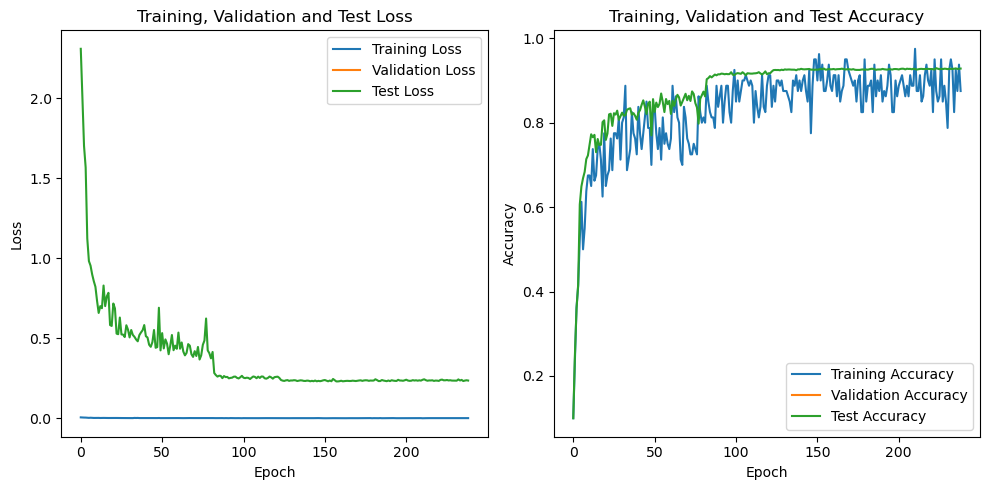

In [25]:
view = LogViewer(logs)
view.draw()

In [26]:
view.print_all()

1 epoch: train_loss=0.0058, train_acc=0.1000, test_loss=2.3102, test_acc=0.0999, lr=0.1000
2 epoch: train_loss=0.0049, train_acc=0.2375, test_loss=2.0019, test_acc=0.2486, lr=0.1000
3 epoch: train_loss=0.0046, train_acc=0.3625, test_loss=1.7031, test_acc=0.3590, lr=0.1000
4 epoch: train_loss=0.0044, train_acc=0.4125, test_loss=1.5687, test_acc=0.4162, lr=0.1000
5 epoch: train_loss=0.0034, train_acc=0.5250, test_loss=1.1233, test_acc=0.6063, lr=0.1000
6 epoch: train_loss=0.0028, train_acc=0.6125, test_loss=0.9828, test_acc=0.6489, lr=0.1000
7 epoch: train_loss=0.0035, train_acc=0.5000, test_loss=0.9545, test_acc=0.6685, lr=0.1000
8 epoch: train_loss=0.0029, train_acc=0.5500, test_loss=0.8997, test_acc=0.6835, lr=0.1000
9 epoch: train_loss=0.0022, train_acc=0.6375, test_loss=0.8575, test_acc=0.7138, lr=0.1000
10 epoch: train_loss=0.0024, train_acc=0.6750, test_loss=0.8224, test_acc=0.7224, lr=0.1000
11 epoch: train_loss=0.0029, train_acc=0.6750, test_loss=0.7347, test_acc=0.7472, lr=0.10

In [22]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))

In [23]:
earlystopper.early_stop_counter

80

In [24]:
scheduler.__class__

torch.optim.lr_scheduler.MultiStepLR